In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [268]:
from glob import glob
import os

data_dir = "/kaggle/input/dog-breed-identification"

train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

train_data = sorted(glob(f"{train_dir}/*"))
test_data = sorted(glob(f"{test_dir}/*"))

print(len(train_data), len(test_data))

10222 10357


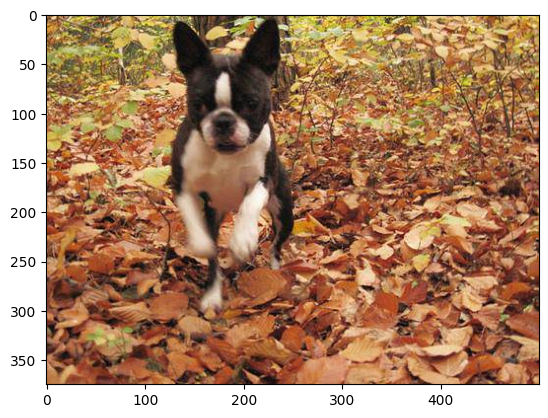

In [269]:
import matplotlib.pyplot as plt

plt.imshow(plt.imread(train_data[0]))

In [270]:
train_labels = []
with open('label.txt', 'r') as file:
    for i in file:
        train_labels.append(int(i))

In [271]:
print(len(train_labels))

10222


In [272]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [273]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [274]:
model = models.efficientnet_b2(pretrained=True)

# class CustomModel(nn.Module):
#     def __init__(self, model):
#         super(CustomModel, self).__init__()
#         self.model = model
#         self.linear = nn.Linear(1000, 120)
        
#     def forward(self, x):
#         x = self.model(x)
#         x = self.linear(x)
    
#         return x
    
# model = CustomModel(model)

model.classifier[0] = nn.Dropout(p=0.2, inplace=True)
model.classifier[1] = nn.Linear(in_features=1408, out_features=120, bias=True)

model.to(device)
# print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [275]:
from PIL import Image
import cv2
import requests

class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, path, y, transform):
        self.path = path
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        x = cv2.imread(self.path[index])
        x = Image.fromarray(x)
        x = self.transform(x)
        
        y = self.y[index]
        
        return x, y

In [276]:
from sklearn.model_selection import train_test_split

train_image, val_image, train_label, val_label = train_test_split(train_data, train_labels, test_size=0.05, stratify=train_labels)

In [277]:
print(len(train_image), len(val_image), len(train_label), len(val_label))

9710 512 9710 512


In [278]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.3920, 0.4519, 0.4763), (0.2155, 0.2173, 0.2227))
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.3920, 0.4519, 0.4763), (0.2155, 0.2173, 0.2227))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [279]:
train_ds = custom_dataset(train_image, train_label, train_transform)
val_ds = custom_dataset(val_image, val_label, val_transform)

In [280]:
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=32)

In [281]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [282]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.2)

In [283]:
from sklearn.metrics import accuracy_score
import tqdm

def train_validate(model, train_dataloader, test_loader, optimizer, loss_func, epochs):
    train_losses = []
    train_accs = []
    validation_losses = []
    validation_accs = []

    for epoch in range(epochs):
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        model.train()

        # 훈련 루프
        for data, target in tqdm.tqdm(train_dataloader):
            
            data = data.to(device)
            target = target.to(device)
            
            y_pred = model(data)
#             print(y_pred.shape)
            loss = loss_func(y_pred, target)

            acc = accuracy_score(target.cpu(), y_pred.argmax(dim=1).detach().cpu())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            epoch_train_acc += acc

        # 에포크 당 평균 훈련 손실 및 정확도
        avg_train_loss = epoch_train_loss / len(train_dataloader)
        avg_train_acc = epoch_train_acc / len(train_dataloader)

        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)

        print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")

        # 검증 루프
        model.eval()
        epoch_validation_loss = 0.0
        with torch.no_grad():
            for data, target in tqdm.tqdm(test_loader):
                
                data = data.to(device)
                target = target.to(device)

                y_pred = model(data)

                loss = loss_func(y_pred, target)

                epoch_validation_loss += loss.item()
        
        avg_validation_loss = epoch_validation_loss / len(test_loader)
        avg_validation_acc = accuracy_score(target.cpu(), y_pred.argmax(dim=1).detach().cpu())
        
        validation_losses.append(avg_validation_loss)
        validation_accs.append(avg_validation_acc)

        print(f"Validation Loss: {avg_validation_loss:.4f}, Validation Acc: {avg_validation_acc:.4f} \n")
        
        if epoch % 2 == 1:
            torch.save(model.state_dict(), f"model_{epoch}.pth")
        
    return train_losses, train_accs, validation_losses, validation_accs

In [284]:
epochs=10

In [285]:
train_losses, train_accs, validation_losses, validation_accs = train_validate(model, train_dataloader, val_dataloader, optimizer, criterion, epochs)

100%|██████████| 303/303 [02:31<00:00,  1.99it/s]


Epoch: 1, Train Loss: 2.7947, Train Acc: 0.3008


100%|██████████| 16/16 [00:03<00:00,  5.03it/s]


Validation Loss: 1.7397, Validation Acc: 0.5312 



100%|██████████| 303/303 [02:31<00:00,  2.00it/s]


Epoch: 2, Train Loss: 1.7055, Train Acc: 0.5064


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Validation Loss: 1.4150, Validation Acc: 0.5000 



100%|██████████| 303/303 [02:31<00:00,  1.99it/s]


Epoch: 3, Train Loss: 1.3344, Train Acc: 0.6030


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Validation Loss: 1.2970, Validation Acc: 0.6562 



100%|██████████| 303/303 [02:32<00:00,  1.98it/s]


Epoch: 4, Train Loss: 1.0978, Train Acc: 0.6646


100%|██████████| 16/16 [00:02<00:00,  5.39it/s]


Validation Loss: 1.3390, Validation Acc: 0.5000 



100%|██████████| 303/303 [02:32<00:00,  1.99it/s]


Epoch: 5, Train Loss: 0.9491, Train Acc: 0.7030


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Validation Loss: 1.2827, Validation Acc: 0.5938 



100%|██████████| 303/303 [02:31<00:00,  2.00it/s]


Epoch: 6, Train Loss: 0.8003, Train Acc: 0.7481


100%|██████████| 16/16 [00:03<00:00,  5.07it/s]


Validation Loss: 1.4592, Validation Acc: 0.5938 



100%|██████████| 303/303 [02:31<00:00,  2.00it/s]


Epoch: 7, Train Loss: 0.7213, Train Acc: 0.7706


100%|██████████| 16/16 [00:02<00:00,  5.51it/s]


Validation Loss: 1.5181, Validation Acc: 0.6562 



100%|██████████| 303/303 [02:32<00:00,  1.99it/s]


Epoch: 8, Train Loss: 0.6231, Train Acc: 0.8021


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Validation Loss: 1.4362, Validation Acc: 0.5312 



100%|██████████| 303/303 [02:33<00:00,  1.97it/s]


Epoch: 9, Train Loss: 0.5661, Train Acc: 0.8178


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Validation Loss: 1.4299, Validation Acc: 0.6562 



100%|██████████| 303/303 [02:32<00:00,  1.99it/s]


Epoch: 10, Train Loss: 0.4933, Train Acc: 0.8407


100%|██████████| 16/16 [00:03<00:00,  5.23it/s]


Validation Loss: 1.4653, Validation Acc: 0.5625 



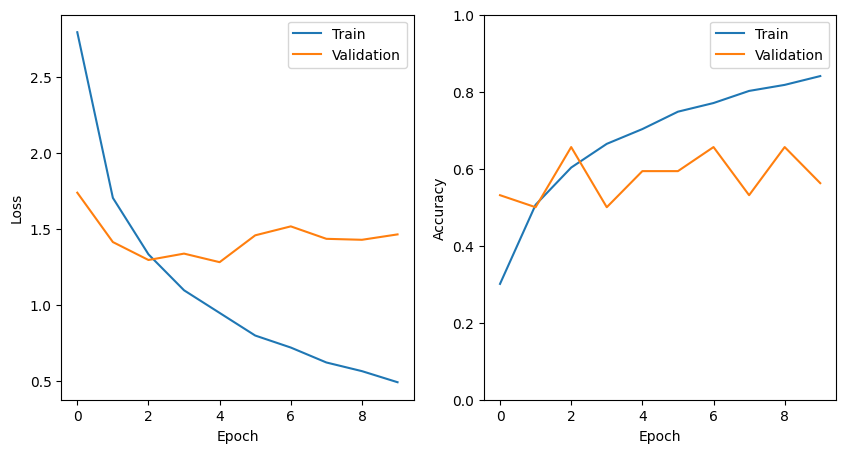

In [286]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(validation_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(validation_accs, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [296]:
model.load_state_dict(torch.load("model_5.pth"))
# model2 = model.load_state_dict(torch.load("model_1.pth"))
# model3 = model.load_state_dict(torch.load("model_2.pth"))
# model4 = model.load_state_dict(torch.load("model_3.pth"))
# model5 = model.load_state_dict(torch.load("model_4.pth"))

/tmp/ipykernel_36/2129841233.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_5.pth"))


<All keys matched successfully>

In [297]:
def predict(model, dataloader):
    model.eval()  # 평가 모드로 전환
    all_preds = []

    with torch.no_grad():  # 그래디언트 계산 비활성화

        for data in dataloader:
            data = data.to(device)  # 데이터를 장치로 이동
            
            # 모델 예측
            outputs = model(data)
            # preds = outputs.argmax(dim=1)
            
            probabilities = F.softmax(outputs, dim=1)

            # # 예측값을 리스트에 추가
            all_preds.append(probabilities.cpu().numpy())

    return all_preds

In [298]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform):
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.path)

    def __getitem__(self, index):
        x = cv2.imread(self.path[index])
        x = Image.fromarray(x)
        x = self.transform(x)

        return x

In [299]:
test_ds = TestDataset(test_data, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=32)

In [300]:
preds1 = predict(model, test_dataloader)
# preds2 = predict(model, test_dataloader)
# preds3 = predict(model, test_dataloader)
# preds4 = predict(model, test_dataloader)
# preds5 = predict(model, test_dataloader)

In [301]:
real_preds = [row for matrix in preds1 for row in matrix]

In [302]:
test_data_id = []

for i in range(len(test_data)):
    temp = test_data[i].split('/')[-1].split('.jpg')[0]
    test_data_id.append(temp)

len(test_data_id)

10357

In [303]:
import pandas as pd

label_df = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
# label_df

class_names = label_df['breed'].unique()
class_names = sorted(class_names)
# class_names

id_df = pd.DataFrame({'id' : test_data_id})
# id_df

result_df = pd.DataFrame(real_preds, columns=class_names)
# result_df

In [304]:
real_result = pd.concat([id_df, result_df], axis=1)
real_result.to_csv('answer3.csv', index=False)

In [7]:
# import pandas as pd

# label_df = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
# # label_df

# class_names = label_df['breed'].unique()
# class_names = sorted(class_names)
# print(class_names)

# label_dict = dict(zip(label_df.iloc[:, 0], label_df.iloc[:, 1]))
# print(label_dict)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

In [8]:
# train_label = []
# for i in range(len(train_data)):
#     label_str = label_dict[train_data[i].split('/')[-1].split('.jpg')[0]]
#     label_index = class_names.index(label_str)
# #     print(label_index, label_str)
#     train_label.append(label_index)

# file_name = './label.txt'

# with open(file_name, 'w') as file:
#     for item in train_label:
#         file.write(str(item) + '\n')

In [51]:
# mean = 0.0
# std = 0.0
# n_samples = 0

# for images, _ in train_dataloader:
#     # 이미지의 배치 크기 (B, C, H, W)
#     batch_samples = images.size(0)  # 배치 내 이미지 수
#     images = images.view(batch_samples, images.size(1), -1)  # (B, C, H*W)
    
#     # 배치 평균과 표준편차 계산
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)
#     n_samples += batch_samples

# # 평균과 표준편차 최종 값
# mean /= n_samples
# std /= n_samples

# print(mean, std)